<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session13/ViT_Cats_n_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vit-pytorch linformer

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

In [3]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [4]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile

In [5]:
from sklearn.model_selection import train_test_split 

In [6]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

#Get the dataset from Kaggle

In [7]:
! pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mittalneha","key":"65e70efef2baf98548a6f0949708be30"}'}

In [9]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 270M/271M [00:03<00:00, 84.4MB/s]
100% 271M/271M [00:03<00:00, 78.5MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 36.8MB/s]
 99% 537M/544M [00:07<00:00, 84.6MB/s]
100% 544M/544M [00:07<00:00, 73.1MB/s]


In [11]:
!kaggle -v

Kaggle API 1.5.4


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available:", use_cuda)
print("Selected Device:", device)
seed = 1
# For reproducibility
torch.manual_seed(seed)

# if use_cuda:
#     torch.cuda.manual_seed(seed)
#     BATCH_SIZE=256
# else:
#     BATCH_SIZE=32
# print("Batch Size", BATCH_SIZE)

CUDA Available: True
Selected Device: cuda


#Load Data

In [13]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [14]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

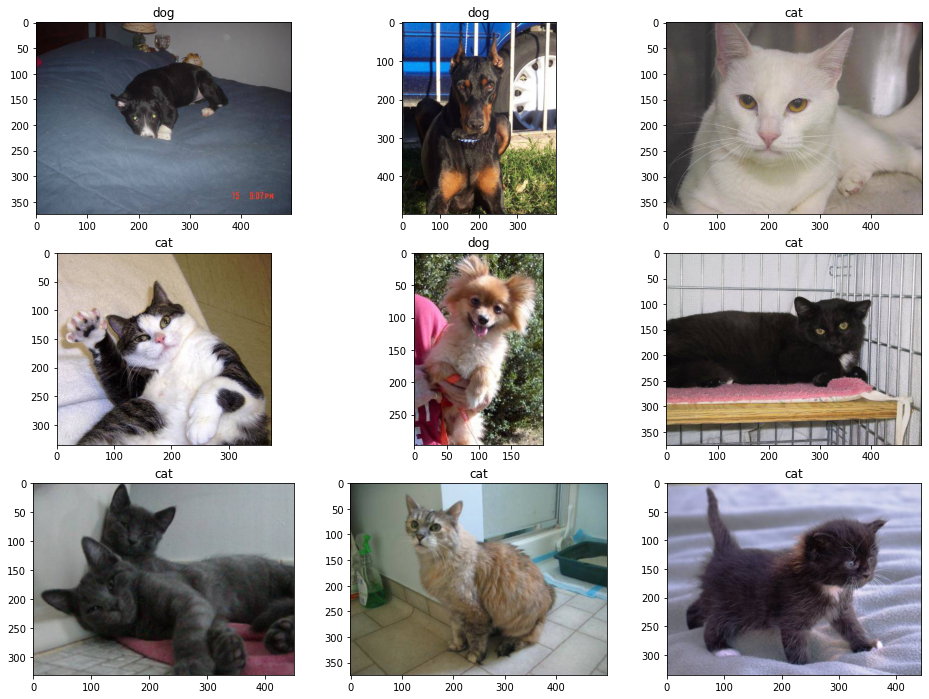

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [18]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

#defining train, validation and test dataset

In [19]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

#Visual transformer 

In [22]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
history = [[0]*5]*epochs

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    history[epoch] = [epoch, epoch_loss.item(), epoch_accuracy.item(), epoch_val_loss.item(), epoch_val_accuracy.item()]


Epoch : 1 - loss : 0.6951 - acc: 0.5059 - val_loss : 0.6911 - val_acc: 0.5162




Epoch : 2 - loss : 0.6911 - acc: 0.5231 - val_loss : 0.6941 - val_acc: 0.5174




Epoch : 3 - loss : 0.6871 - acc: 0.5402 - val_loss : 0.6852 - val_acc: 0.5384




Epoch : 4 - loss : 0.6807 - acc: 0.5584 - val_loss : 0.6712 - val_acc: 0.5837




Epoch : 5 - loss : 0.6738 - acc: 0.5807 - val_loss : 0.6711 - val_acc: 0.5825




Epoch : 6 - loss : 0.6662 - acc: 0.5904 - val_loss : 0.6511 - val_acc: 0.6050




Epoch : 7 - loss : 0.6520 - acc: 0.6023 - val_loss : 0.6491 - val_acc: 0.6167




Epoch : 8 - loss : 0.6453 - acc: 0.6163 - val_loss : 0.6373 - val_acc: 0.6206




Epoch : 9 - loss : 0.6417 - acc: 0.6253 - val_loss : 0.6323 - val_acc: 0.6284




Epoch : 10 - loss : 0.6348 - acc: 0.6311 - val_loss : 0.6265 - val_acc: 0.6345




Epoch : 11 - loss : 0.6248 - acc: 0.6448 - val_loss : 0.6216 - val_acc: 0.6505




Epoch : 12 - loss : 0.6189 - acc: 0.6497 - val_loss : 0.6042 - val_acc: 0.6634




Epoch : 13 - loss : 0.6171 - acc: 0.6494 - val_loss : 0.6080 - val_acc: 0.6644




Epoch : 14 - loss : 0.6085 - acc: 0.6568 - val_loss : 0.6039 - val_acc: 0.6707




Epoch : 15 - loss : 0.6060 - acc: 0.6614 - val_loss : 0.5953 - val_acc: 0.6744




Epoch : 16 - loss : 0.6036 - acc: 0.6689 - val_loss : 0.5940 - val_acc: 0.6719




Epoch : 17 - loss : 0.5914 - acc: 0.6784 - val_loss : 0.5890 - val_acc: 0.6816




Epoch : 18 - loss : 0.5915 - acc: 0.6794 - val_loss : 0.5875 - val_acc: 0.6802




Epoch : 19 - loss : 0.5874 - acc: 0.6832 - val_loss : 0.5871 - val_acc: 0.6847




Epoch : 20 - loss : 0.5881 - acc: 0.6831 - val_loss : 0.5829 - val_acc: 0.6887



In [55]:
his = history

In [56]:
for r in range(len(history)):
    for c in range(len(history[0])):
        if type(history[r][c]) == torch.Tensor:
            history[r][c] = history[r][c].item()

In [57]:
history = np.array(history).transpose(1,0)

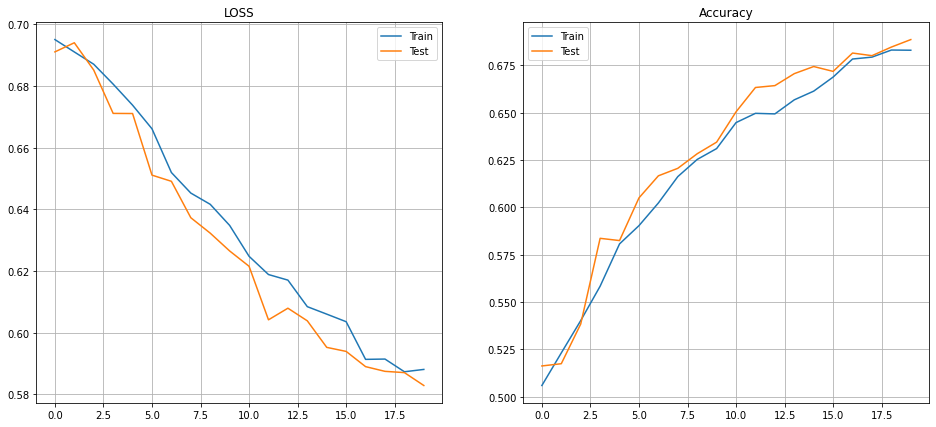

In [58]:

fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[2], label='Train')
axs[1].plot(history[4], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [59]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [60]:
torch.save(model.state_dict(),"/gdrive/MyDrive/EVA6/ViT/model_20.pt")

In [ ]:
model_path = '/gdrive/MyDrive/EVA6/ViT/model_20.pt'
model.load_state_dict(torch.load(model_path))

#Show misclassified images

In [61]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 160 (delta 72), reused 39 (delta 12), pack-reused 0
Receiving objects: 100% (160/160), 50.70 KiB | 355.00 KiB/s, done.
Resolving deltas: 100% (72/72), done.


In [89]:
from vision_pytorch.utils.plotting_functions import plot_misclassified

In [91]:
classes = ['cat', 'dog']

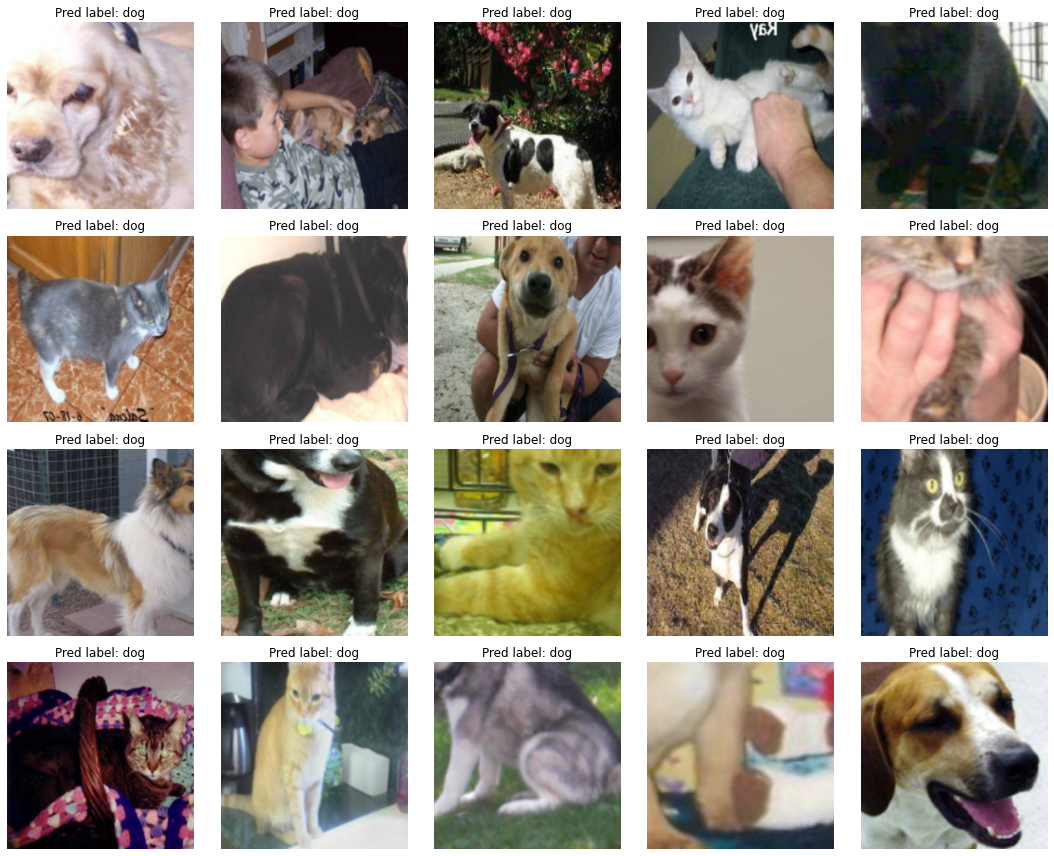

In [90]:
plot_misclassified(model, test_loader, ['cat', 'dog'], device, [0,0,0], [1,1,1])

#Run the model on some test images

In [72]:
!ls /gdrive/MyDrive/EVA6/ViT/test_images/download.jpeg

'download (1).jpeg'  'images (1).jpeg'	'images (3).jpeg'
 download.jpeg	     'images (2).jpeg'	 images.jpeg


Text(0.5, 1.0, 'Pred label: cat')

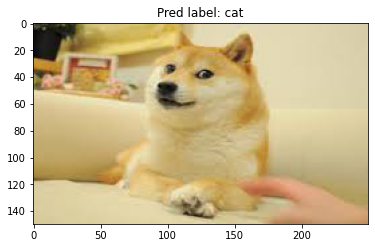

In [97]:
img1 = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (1).jpeg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

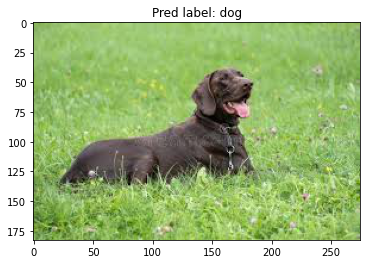

In [99]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/images (3).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

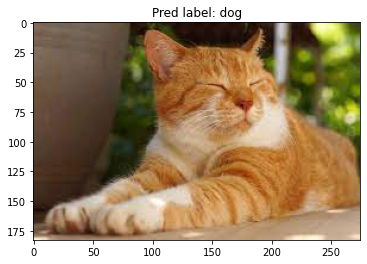

In [103]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (2).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

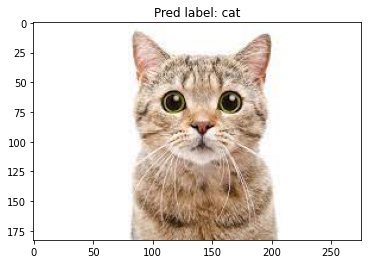

In [101]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (3).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

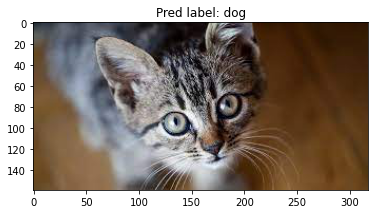

In [102]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (4).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")